In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import torch
import torch.nn as nn
import math 
import cv2

import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/architecture/arch.png
/kaggle/input/pika128/pika128.jpg
/kaggle/input/grayscale/pytorch/default/1/model_grayscale_1.pth
/kaggle/input/apples/apple.jpg
/kaggle/input/image1/may.jpeg
/kaggle/input/images128/images.jpeg
/kaggle/input/128x128-image/selfie2-128x128.jpg


In [2]:
img = Image.open("/kaggle/input/pika128/pika128.jpg").convert("RGB")
print("Image Size: ",img.size)
print("Image Mode: ",img.mode)
print("Image Dimmensions: ", np.array(img).shape)

Image Size:  (128, 128)
Image Mode:  RGB
Image Dimmensions:  (128, 128, 3)


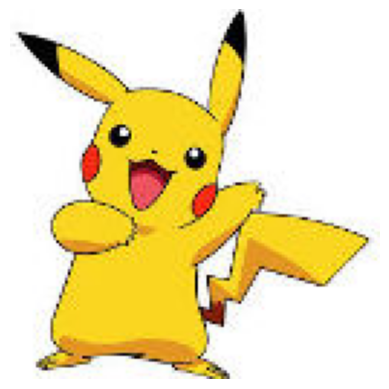

In [3]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [32]:
# converting to grayscale for faster execution
img_grayscale = img.convert("L")
print("Gray Scale Image Size: ",img_grayscale.size)  #(width, height)
print("Gray Scale Image Mode: ",img_grayscale.mode)
print("Gray Scale Image Dimmensions: ", np.array(img_grayscale).shape) #(height, width)

Gray Scale Image Size:  (225, 225)
Gray Scale Image Mode:  L
Gray Scale Image Dimmensions:  (225, 225)


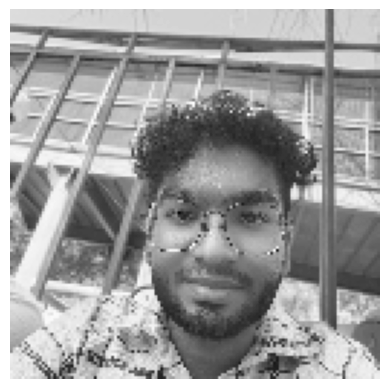

In [9]:
plt.imshow(img_grayscale, cmap="gray")
plt.axis("off")
plt.show()

## Pre processing

### For normalization i am using the min,max normalizatoin instead of sklearn because sklearn normalizes rows by their L2 norm and That’s for feature vectors, not pixel values.
$$
X_{\text{normalized}} = (X - \text{min\_val}) \times \frac{(\text{new\_max} - \text{new\_min})}{(\text{max\_val} - \text{min\_val})} + \text{new\_min}
$$

### For 8 bit grayscale image min value = 0, max value = 255 and the target range is [-1, 1] for sin functions to be used therefore new_min = -1, new_max=1

$$
X_{\text{normalized}} = (X - 0) \times \frac{(1 - (-1))}{(255 - 0)} + (-1)
$$

$$
X_{\text{normalized}} = \left(\frac{X}{255}\right) \times 2 - 1
$$

### Hence this formula i'll be using to normalize.

In [10]:
#Grayscale
# Converting grayscale image into pixels
image_np = np.array(img)

#normalising the image
pixels = (image_np/255.0)*2 -1
print("Initial Shape: ",pixels.shape)

pixels_reshape = pixels.reshape(-1,1)
print("Now Shape: ", pixels_reshape.shape)

Initial Shape:  (128, 128)
Now Shape:  (16384, 1)


In [11]:
H, W = image_np.shape

x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)

xx, yy = np.meshgrid(x,y, indexing="xy")

coords = np.stack([xx, yy],axis=-1).reshape(-1, 2)

X = torch.tensor(coords, dtype = torch.float32) # Coordinates flatten -> Given as input to siren
Y = torch.tensor(pixels_reshape, dtype = torch.float32) # GT used for MSE and Back propogation MSE(Y', Y)

In [ ]:
# #RGB
# # Convert image to NumPy array and normalize to [0, 1]
# img_np = np.array(img).astype(np.float32) / 255.0 # (H, W, 3)

# # Prepare coordinates (X)
# # Generate a grid of normalized coordinates from -1 to 1
# x_coords = torch.linspace(-1, 1, original_width)
# y_coords = torch.linspace(-1, 1, original_height)
# X = torch.stack(torch.meshgrid(x_coords, y_coords, indexing='xy'), dim=-1) # (H, W, 2)
# X = X.reshape(-1, 2) # Flatten to (num_pixels, 2)

# # Prepare target pixel values (Y)
# Y = torch.from_numpy(img_np).reshape(-1, 3) # *** IMPORTANT: Reshape to (num_pixels, 3) for RGB ***

# # Move to device (GPU) - this should be done after loading and preprocessing
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X = X.to(device)
# Y = Y.to(device) #

## Model building

### Concept i followed
    nn.Linear → Sine Activation → nn.Linear → Sine → ... → Final Output
1. Since i'm using a custom AF, so i am required to have custom weight initialization as well, as He and Xavior are Relu/Tanh optimizied

In [15]:
# Creating sine activation function 
class sine_af(nn.Module):
    def __init__(self, w0 = 1):
        super().__init__()
        self.w0 = w0


    def forward(self, x):
        return torch.sin((self.w0)*x)

### This frequency term follow a very very important role in this SIREN, instead of using directly
$$sin(x)$$ 
### which converges lately for higher signals we add a frequency w0 to make it converge faster and capture high details
$$ sin(ω₀ * x) $$
### Also sins are infinitely differentiable thus allowing SIRENs to capture the detials even at 1st and 2nd derivatives which Relu and Tanh suffered from.
### Also adding w0 solves the problem of diminishing gradient or vanishing gradient, as 
$$ y = sin(ω₀ * x)$$
$$
\frac{dy}{dx} = \omega_0 \cdot \cos(\omega_0 \cdot x)
$$
        
                                                                         and
$$
\frac{d^2y}{dx^2} = -\omega_0^2 \cdot \sin(\omega_0 \cdot x)
$$

### So If ω₀ is large (like 30), the magnitude of the gradient (derivative) is also scaled up by ω₀.

### While a Sine AF could map to [-1, 1], a linear output layer is standard for regression tasks because it offers maximum flexibility. The network's capacity to learn the [-1, 1] range (or any other target range) comes from the preceding layers and the training process, not from a final output activation function. Therefore we haven't applied sine af to the final layer

In [16]:
def siren_self_weights(layer, is_first_layer = False, w0_initial = 30.0):
    if isinstance(layer, nn.Linear):
        fan_in = layer.in_features
    
        if is_first_layer:
            limit = 1/ fan_in
    
        else:
            limit = (math.sqrt(6/fan_in))/w0_initial
    
        layer.weight.data.uniform_(-limit, limit)
        layer.bias.data.fill_(0)

# def siren_self_weights(layer, is_first_layer=False, w0_initial=30.0, c=6):
#     if isinstance(layer, nn.Linear):
        
#         fan_in = layer.weight.size(1)
#         if is_first_layer:
#             limit = math.sqrt(c / fan_in) / w0_initial
#         else:
#             limit = math.sqrt(c / fan_in)
#         layer.weight.data.uniform_(-limit, limit)
#         layer.bias.data.fill_(0)

In [17]:
class Siren(nn.Module):
    def __init__(self, inputs,hidden_features, hidden_layers, output_number, frequency_initial = 30, frequency = 1):
        super(Siren, self).__init__()

        self.lists = []
    
        # First Layer
        first_layer = nn.Linear(inputs, hidden_features)
        siren_self_weights(first_layer, is_first_layer = True, w0_initial = frequency_initial)
        self.lists.append(first_layer)
        # applying AF
        self.lists.append(sine_af(w0 = frequency_initial))
    
        # Hidden Layers
        for hidden_layer in range(hidden_layers):
            
            layer = nn.Linear(hidden_features, hidden_features)
            siren_self_weights(layer, is_first_layer=False, w0_initial = frequency)
            self.lists.append(layer)
            # Applying AF
            self.lists.append(sine_af(w0 = frequency))

        # Final layer
        final_layer = nn.Linear(hidden_features, output_number)
        siren_self_weights(final_layer, is_first_layer = False, w0_initial = frequency)
        self.lists.append(final_layer)

        self.net = nn.Sequential(*self.lists)


    def forward(self, x):
        return self.net(x)

In [15]:
model = Siren(inputs=2, hidden_features=256, hidden_layers=3, output_number=1,
              frequency_initial=30, frequency=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [16]:
# --- Move model and data to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Siren(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): sine_af()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): sine_af()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): sine_af()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): sine_af()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
X = X.to(device)
Y = Y.to(device)

In [18]:
print(f"X tensor is on: {X.device}")
print(f"Y tensor is on: {Y.device}")

X tensor is on: cuda:0
Y tensor is on: cuda:0


In [15]:
num_epochs = 10000
losses = []

print("Training started")
# Training Loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X)

    # Compute Loss
    loss = criterion(outputs, Y)
    losses.append(loss.item())

    # Backward + Optimize
    loss.backward()
    optimizer.step()

    #logging
    if (epoch + 1) % 100 == 0: # Print loss every 100 epochs
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print("Training finished!")

Training started
Epoch [100/10000], Loss: 0.030920
Epoch [200/10000], Loss: 0.016832
Epoch [300/10000], Loss: 0.013525
Epoch [400/10000], Loss: 0.011770
Epoch [500/10000], Loss: 0.010607
Epoch [600/10000], Loss: 0.009757
Epoch [700/10000], Loss: 0.009100
Epoch [800/10000], Loss: 0.008575
Epoch [900/10000], Loss: 0.008141
Epoch [1000/10000], Loss: 0.007774
Epoch [1100/10000], Loss: 0.007456
Epoch [1200/10000], Loss: 0.007175
Epoch [1300/10000], Loss: 0.006924
Epoch [1400/10000], Loss: 0.006696
Epoch [1500/10000], Loss: 0.006486
Epoch [1600/10000], Loss: 0.006292
Epoch [1700/10000], Loss: 0.006112
Epoch [1800/10000], Loss: 0.005943
Epoch [1900/10000], Loss: 0.005784
Epoch [2000/10000], Loss: 0.005634
Epoch [2100/10000], Loss: 0.005490
Epoch [2200/10000], Loss: 0.005353
Epoch [2300/10000], Loss: 0.005220
Epoch [2400/10000], Loss: 0.005092
Epoch [2500/10000], Loss: 0.004967
Epoch [2600/10000], Loss: 0.004844
Epoch [2700/10000], Loss: 0.004724
Epoch [2800/10000], Loss: 0.004606
Epoch [2900/

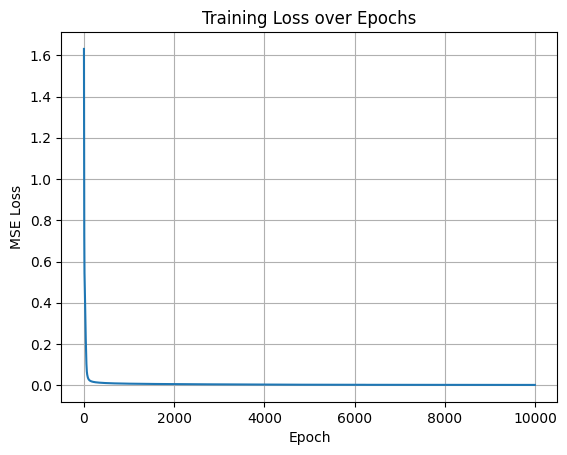

In [16]:
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

In [17]:
model.eval()  # Set model to eval mode (very important)

with torch.no_grad():
    preds = model(X.to(device)).cpu().numpy()

In [18]:
output_image = preds.reshape(H, W)

In [19]:
output_image = ((output_image + 1) / 2.0) * 255
output_image = np.clip(output_image, 0, 255).astype(np.uint8)

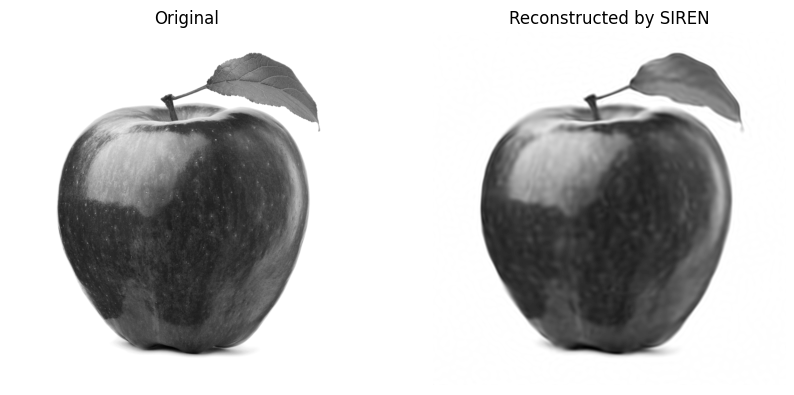

In [20]:
plt.figure(figsize=(10,5))

# Ground truth
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image_np, cmap="gray")
plt.axis("off")

# Reconstructed
plt.subplot(1, 2, 2)
plt.title("Reconstructed by SIREN")
plt.imshow(output_image, cmap="gray")
plt.axis("off")

plt.show()

In [29]:
def psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))



In [ ]:
print("PSNR:", psnr(image_np, output_image))

In [22]:
# Furthur optimization
torch.save(model.state_dict(), 'siren_model_epoch_10000.pth')
print("Model state saved to siren_model_epoch_10000.pth")

Model state saved to siren_model_epoch_10000.pth


In [23]:
model_save_path = '/kaggle/working/siren_model_epoch_10000.pth' # Make sure this path is correct!
try:
    model.load_state_dict(torch.load(model_save_path))
    print(f"Loaded model weights from: {model_save_path}")
except FileNotFoundError:
    print(f"Error: Model weights not found at {model_save_path}. Please ensure you saved the model after the first 10000 epochs, or update the path.")
    print("Exiting or continuing from scratch (if not intended, fix the path and restart).")
    # You might want to sys.exit() here if loading is mandatory
    # import sys
    # sys.exit()

Loaded model weights from: /kaggle/working/siren_model_epoch_10000.pth


In [24]:
# --- Define Criterion (Loss function) ---
criterion = nn.MSELoss()

# This is crucial for fine-tuning
new_lr = 5e-5 # This is half of your previous 1e-4. You could even try 1e-5 if needed later.
optimizer = torch.optim.Adam(model.parameters(), lr=new_lr)
print(f"Optimizer initialized with new learning rate: {new_lr}")

Optimizer initialized with new learning rate: 5e-05


In [25]:
# --- Define Continuation Epochs ---
start_epoch = 10000 # Assuming previous training ran for 10000 epochs
additional_epochs = 10000 # Let's aim for another 10,000 epochs
total_epochs = start_epoch + additional_epochs

# Reset losses list for this new training phase if you want to track fresh progress,
# or append to existing 'losses' list if you loaded previous 'losses' data.
losses = []

print(f"Continuing training from epoch {start_epoch} up to {total_epochs} with LR: {new_lr}")

# --- Training Loop ---
# The loop now starts from the 'start_epoch'
for epoch in range(start_epoch, total_epochs):
    model.train() # Set model to training mode
    optimizer.zero_grad() # Clear gradients

    # Forward Pass
    outputs = model(X)

    # Compute Loss
    loss = criterion(outputs, Y)
    losses.append(loss.item())

    # Backward + Optimize
    loss.backward()
    optimizer.step()

    # Logging
    if (epoch + 1) % 100 == 0: # Print loss every 100 epochs
        # Ensure you include the total_epochs in your print statement for clarity
        print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {loss.item():.6f}")

print("Continued training finished!")

Continuing training from epoch 10000 up to 20000 with LR: 5e-05
Epoch [10100/20000], Loss: 0.001735
Epoch [10200/20000], Loss: 0.001731
Epoch [10300/20000], Loss: 0.001727
Epoch [10400/20000], Loss: 0.001722
Epoch [10500/20000], Loss: 0.001717
Epoch [10600/20000], Loss: 0.001712
Epoch [10700/20000], Loss: 0.001710
Epoch [10800/20000], Loss: 0.001701
Epoch [10900/20000], Loss: 0.001696
Epoch [11000/20000], Loss: 0.001690
Epoch [11100/20000], Loss: 0.001686
Epoch [11200/20000], Loss: 0.001685
Epoch [11300/20000], Loss: 0.001674
Epoch [11400/20000], Loss: 0.001670
Epoch [11500/20000], Loss: 0.001672
Epoch [11600/20000], Loss: 0.001659
Epoch [11700/20000], Loss: 0.001657
Epoch [11800/20000], Loss: 0.001663
Epoch [11900/20000], Loss: 0.001651
Epoch [12000/20000], Loss: 0.001640
Epoch [12100/20000], Loss: 0.001635
Epoch [12200/20000], Loss: 0.001630
Epoch [12300/20000], Loss: 0.001628
Epoch [12400/20000], Loss: 0.001621
Epoch [12500/20000], Loss: 0.001620
Epoch [12600/20000], Loss: 0.001613


In [26]:
model.eval()  # Set model to eval mode (very important)

with torch.no_grad():
    preds = model(X.to(device)).cpu().numpy()

In [27]:
output_image = preds.reshape(H, W)
output_image = ((output_image + 1) / 2.0) * 255
output_image = np.clip(output_image, 0, 255).astype(np.uint8)

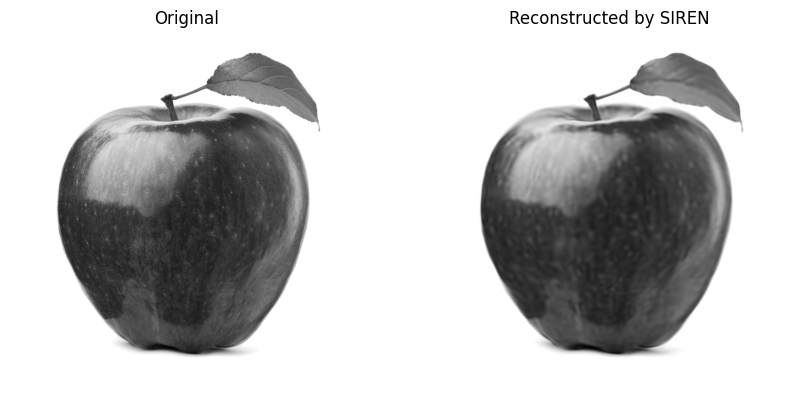

In [28]:
plt.figure(figsize=(10,5))

# Ground truth
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image_np, cmap="gray")
plt.axis("off")

# Reconstructed
plt.subplot(1, 2, 2)
plt.title("Reconstructed by SIREN")
plt.imshow(output_image, cmap="gray")
plt.axis("off")

plt.show()

In [29]:
print("PSNR:", psnr(image_np, output_image))

PSNR: 36.69596649828968


In [30]:
torch.save(model, "model_grayscale.pth")

In [31]:
torch.save(model.state_dict(), "model_grayscale_1.pth")

In [19]:
# Upsmapling
model.load_state_dict(torch.load('/kaggle/input/grayscale/pytorch/default/1/model_grayscale_1.pth'))
model.eval()

Siren(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): sine_af()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): sine_af()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): sine_af()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): sine_af()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Siren(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): sine_af()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): sine_af()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): sine_af()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): sine_af()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [21]:
(H,W)

(128, 128)

In [22]:
upsample_factor = 8
print(f"Attempting {upsample_factor}x upsampling...")

# --- 3. Calculate New Upsampled Dimensions ---
# Use math.ceil to ensure dimensions are integers, especially if not perfectly divisible
upsampled_height = math.ceil(H * upsample_factor)
upsampled_width = math.ceil(W * upsample_factor)
print(f"Upsampled resolution: {upsampled_width}x{upsampled_height}")

# --- 4. Generate New, Denser Coordinate Grid for Upsampled Resolution ---
# Coordinates should still be normalized between -1 and 1
x_coords_up = torch.linspace(-1, 1, upsampled_width)
y_coords_up = torch.linspace(-1, 1, upsampled_height)
# Create a grid of (x, y) pairs
X_upsampled = torch.stack(torch.meshgrid(x_coords_up, y_coords_up, indexing='xy'), dim=-1)
X_upsampled = X_upsampled.reshape(-1, 2) # Flatten to (num_pixels, 2)
X_upsampled = X_upsampled.to(device) # Move to GPU

Attempting 8x upsampling...
Upsampled resolution: 1024x1024


In [26]:
# --- 5. Query the Trained SIREN Model with the Upsampled Coordinates ---
print("Querying model for upsampled image...")
with torch.no_grad(): # No need for gradients during inference
    # If your model was wrapped with DataParallel for training,
    # it's usually fine to use it directly for inference.
    # If you loaded model.module's state_dict into a non-DataParallel model, that's fine too.
    upsampled_outputs = model(X_upsampled).cpu().numpy()

Querying model for upsampled image...


In [27]:
# --- 6. Reshape Output to New Image Dimensions ---
# Ensure values are clipped to [0, 1] and then scaled to [0, 255] for image saving
upsampled_image_array = upsampled_outputs.reshape(upsampled_height, upsampled_width) # Assuming 3 channels for color
upsampled_image_array = np.clip(upsampled_image_array, 0, 1) # Clip values to [0, 1] range
upsampled_image_array = (upsampled_image_array * 255).astype(np.uint8) # Scale to [0, 255] and convert to uint8

# --- 7. Convert to PIL Image and Save/Display ---
upsampled_pil_image = Image.fromarray(upsampled_image_array)
upsampled_image_path = 'siren_upsampled_4x.png'
upsampled_pil_image.save(upsampled_image_path)
print(f"4x upsampled image saved to: {upsampled_image_path}")

# Display (optional, requires matplotlib)
# import matplotlib.pyplot as plt

4x upsampled image saved to: siren_upsampled_4x.png


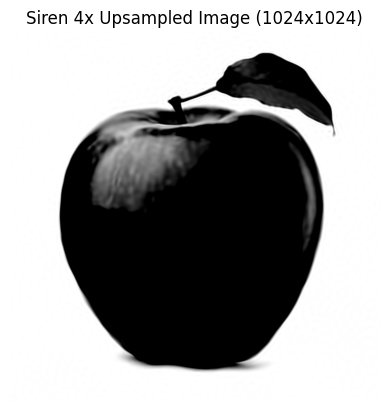

In [28]:
plt.imshow(upsampled_pil_image, cmap="gray")
plt.title(f'Siren 4x Upsampled Image ({upsampled_width}x{upsampled_height})')
plt.axis('off')
plt.show()

# Colores

In [12]:
def preprocess(img):
    # Converting grayscale image into pixels
    image_np = np.array(img)

    #normalising the image
    if len(image_np.shape) == 2:
        # Grayscale
        pixels = (image_np / 255.0) * 2 - 1
        pixels_reshape = pixels.reshape(-1, 1)
        H, W = image_np.shape
    else:
        # Color
        pixels = (image_np / 255.0) * 2 - 1
        H, W, C = image_np.shape
        # print(C)
        pixels_reshape = pixels.reshape(-1, C)

    x = np.linspace(-1, 1, W)
    y = np.linspace(-1, 1, H)

    xx, yy = np.meshgrid(x,y, indexing="xy")

    coords = np.stack([xx, yy],axis=-1).reshape(-1, 2)

    X = torch.tensor(coords, dtype = torch.float32) # Coordinates flatten -> Given as input to siren
    Y = torch.tensor(pixels_reshape, dtype = torch.float32) # GT used for MSE and Back propogation MSE(Y', Y)
    return X, Y, H, W

In [13]:
X, Y, H, W = preprocess(img)

3


In [18]:
model = Siren(inputs=2, hidden_features=256, hidden_layers=3, output_number=3,
              frequency_initial=30, frequency=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [19]:
# --- Move model and data to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X = X.to(device)
Y = Y.to(device)

In [20]:
num_epochs = 10000
losses = []

print("Training started")
# Training Loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X)

    # Compute Loss
    loss = criterion(outputs, Y)
    losses.append(loss.item())

    # Backward + Optimize
    loss.backward()
    optimizer.step()

    #logging
    if (epoch + 1) % 100 == 0: # Print loss every 100 epochs
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print("Training finished!")

Training started
Epoch [100/10000], Loss: 0.098674
Epoch [200/10000], Loss: 0.057358
Epoch [300/10000], Loss: 0.048366
Epoch [400/10000], Loss: 0.044000
Epoch [500/10000], Loss: 0.041220
Epoch [600/10000], Loss: 0.039206
Epoch [700/10000], Loss: 0.037621
Epoch [800/10000], Loss: 0.036298
Epoch [900/10000], Loss: 0.035147
Epoch [1000/10000], Loss: 0.034113
Epoch [1100/10000], Loss: 0.033164
Epoch [1200/10000], Loss: 0.032277
Epoch [1300/10000], Loss: 0.031439
Epoch [1400/10000], Loss: 0.030638
Epoch [1500/10000], Loss: 0.029867
Epoch [1600/10000], Loss: 0.029117
Epoch [1700/10000], Loss: 0.028383
Epoch [1800/10000], Loss: 0.027659
Epoch [1900/10000], Loss: 0.026938
Epoch [2000/10000], Loss: 0.026219
Epoch [2100/10000], Loss: 0.025497
Epoch [2200/10000], Loss: 0.024770
Epoch [2300/10000], Loss: 0.024038
Epoch [2400/10000], Loss: 0.023299
Epoch [2500/10000], Loss: 0.022552
Epoch [2600/10000], Loss: 0.021794
Epoch [2700/10000], Loss: 0.021023
Epoch [2800/10000], Loss: 0.020233
Epoch [2900/

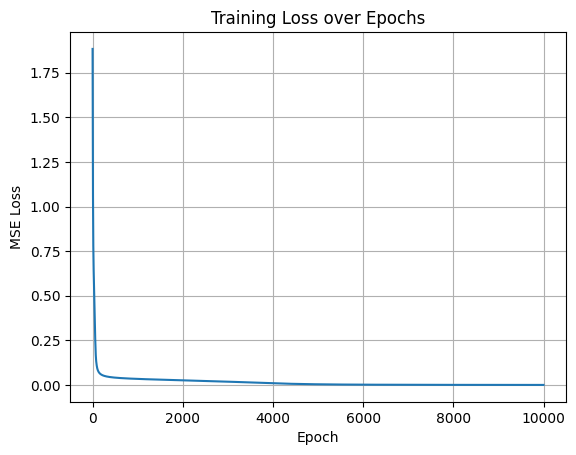

In [21]:
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

In [22]:
model.eval()  # Set model to eval mode (very important)

with torch.no_grad():
    preds = model(X.to(device)).cpu().numpy()

In [24]:
output_image = preds.reshape(H, W,3)
output_image = ((output_image + 1) / 2.0) * 255
output_image = np.clip(output_image, 0, 255).astype(np.uint8)

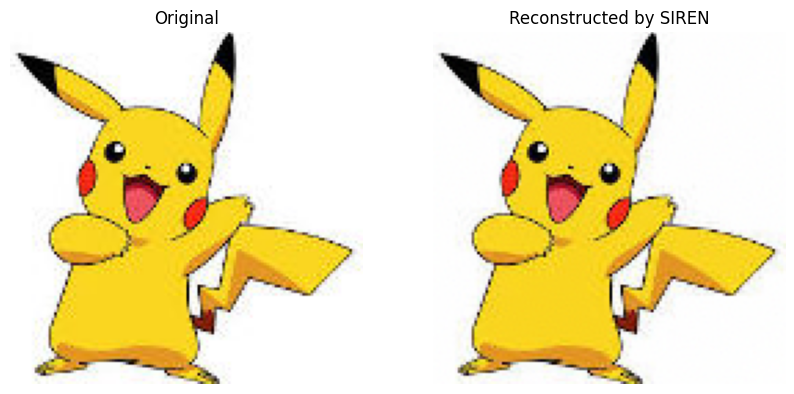

In [27]:
plt.figure(figsize=(10,5))

# Ground truth
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

# Reconstructed
plt.subplot(1, 2, 2)
plt.title("Reconstructed by SIREN")
plt.imshow(output_image)
plt.axis("off")

plt.show()

In [30]:
print("PSNR:", psnr(img, output_image))

PSNR: 40.53693814411109


In [31]:
torch.save(model.state_dict(), "colored.pth")

In [54]:
#Upsampling
# --- 1. Define Upsampling Factor ---
upsample_factor = 16
print(f"Attempting {upsample_factor}x upsampling...")

# --- 2. Calculate New Upsampled Dimensions ---
# H and W should come from your preprocess function's return values
upsampled_height = math.ceil(H * upsample_factor)
upsampled_width = math.ceil(W * upsample_factor)
print(f"Upsampled resolution: {upsampled_width}x{upsampled_height}")

Attempting 16x upsampling...
Upsampled resolution: 2048x2048


In [55]:
# --- 3. Generate New, Denser Coordinate Grid for Upsampled Resolution ---
# Coordinates should still be normalized between -1 and 1
x_coords_up = torch.linspace(-1, 1, upsampled_width)
y_coords_up = torch.linspace(-1, 1, upsampled_height)
# Create a grid of (x, y) pairs
X_upsampled = torch.stack(torch.meshgrid(x_coords_up, y_coords_up, indexing='xy'), dim=-1)
X_upsampled = X_upsampled.reshape(-1, 2) # Flatten to (num_pixels, 2)
X_upsampled = X_upsampled.to(device) # Move ALL upsampled coordinates to GPU

In [56]:
# --- 4. Query the Trained SIREN Model with the Upsampled Coordinates ---
print("Querying model for upsampled image...")
with torch.no_grad(): # No need for gradients during inference
    # This will attempt to run the entire upsampling in one go
    upsampled_outputs = model(X_upsampled).cpu().numpy()

# --- 5. Reshape Output to New Image Dimensions and Scale for Image Saving ---
# Step A: Convert model's [-1, 1] output to [0, 1]
upsampled_image_array = (upsampled_outputs + 1) / 2.0

# Step B: Reshape to (Height, Width, Channels) for color image (THIS IS CRUCIAL)
upsampled_image_array = upsampled_image_array.reshape(upsampled_height, upsampled_width, 3) # <--- CORRECT FOR COLOR!

# Step C: Clip values to [0, 1] (important if any values are slightly outside due to network output)
upsampled_image_array = np.clip(upsampled_image_array, 0, 1)

# Step D: Scale to [0, 255] and convert to uint8
upsampled_image_array = (upsampled_image_array * 255).astype(np.uint8)


Querying model for upsampled image...


In [57]:
# --- 6. Convert to PIL Image and Save/Display ---
upsampled_pil_image = Image.fromarray(upsampled_image_array)
upsampled_image_path = f'siren_upsampled_{upsample_factor}x.png' # Corrected filename
upsampled_pil_image.save(upsampled_image_path)
print(f"{upsample_factor}x upsampled image saved to: {upsampled_image_path}")

16x upsampled image saved to: siren_upsampled_16x.png


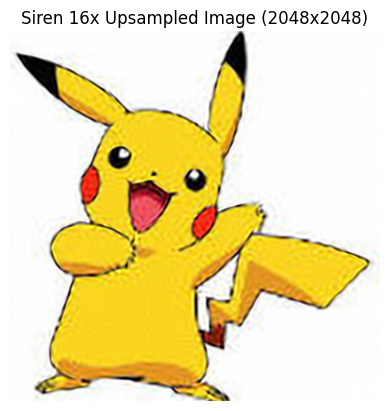

In [58]:
plt.imshow(upsampled_pil_image)
plt.title(f'Siren {upsample_factor}x Upsampled Image ({upsampled_width}x{upsampled_height})')
plt.axis('off')
plt.show()

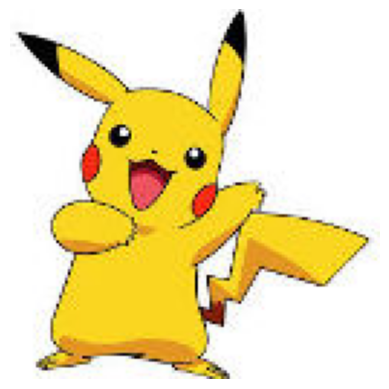

In [59]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [66]:
def sharpen_image(image_array, sharpen_strength=1.5):
    """
    Sharpens an image array using a basic sharpening kernel.
    Args:
        image_array (np.ndarray): The input image array (H, W, 3) and uint8 dtype.
        sharpen_strength (float): Controls the intensity of sharpening.
                                  A common value is between 1.0 and 3.0.
    Returns:
        np.ndarray: The sharpened image array.
    """
    # Define a basic sharpening kernel
    # This kernel emphasizes the center pixel relative to its neighbors
    # kernel = np.array([[-1, -1, -1],
    #                    [-1,  9, -1],
    #                    [-1, -1, -1]]) # Simple sharpening kernel, sum is 1

    # Alternatively, for a stronger effect:
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]]) # Common sharpening kernel, sum is 1

    # Apply the kernel to the image
    # We use cv2.filter2D for convolution
    # -1 indicates that the output image will have the same depth as the input
    sharpened_image = cv2.filter2D(image_array, -1, kernel)

    # Note: For Unsharp Masking, a more robust approach:
    # blurred = cv2.GaussianBlur(image_array, (0,0), 3) # blur with 3 sigma
    # sharpened = cv2.addWeighted(image_array, 1.5, blurred, -0.5, 0) # Adjust weights for strength
    # sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened_image

In [67]:
sharpened_upsampled_array = sharpen_image(upsampled_image_array, sharpen_strength=1.5)
sharpened_upsampled_image = Image.fromarray(sharpened_upsampled_array)

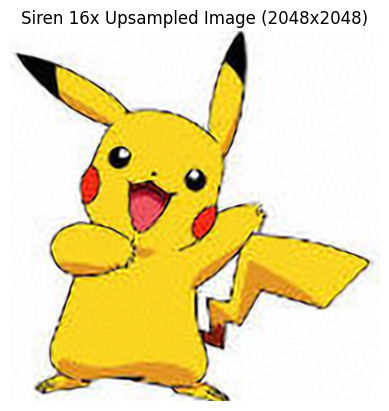

In [68]:
plt.imshow(sharpened_upsampled_image)
plt.title(f'Siren {upsample_factor}x Upsampled Image ({upsampled_width}x{upsampled_height})')
plt.axis('off')
plt.show()